# Crime Data Auto Ingestion Project

Project Description: The aim of the project is to automate continuous data loading from 2020 to Present

Project Link: https://catalog.data.gov/dataset/crime-data-from-2020-to-present

# Import Modules

In [1]:
import os
import boto3
import requests
import warnings
import numpy as np
import pandas as pd
from credentials import *
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt

# Options and Settings

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')

# Load Image

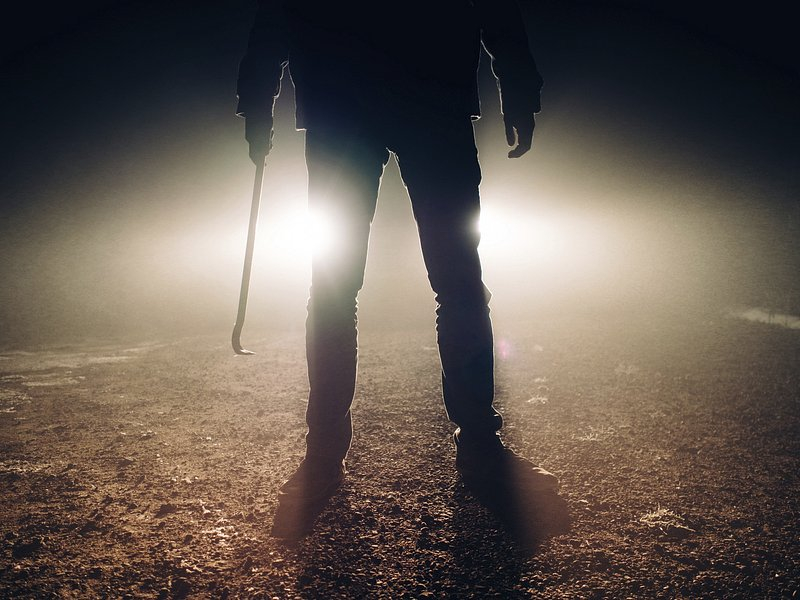

In [3]:
image_url = "https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3B4NzE0NDczLWltYWdlLWt3dnhpYzQ3LmpwZw.jpg"
Image.open(fp=urlopen(f'{image_url}'))

# Get Response

In [4]:
def make_request(url: str) -> dict:
    """
    Get response from website

    Parameters
    ----------

    url: str

    Returns:
      json response
       
    """

    try:
        r = requests.get(f"{url}", timeout=(2, 10))

        if r.status_code == requests.codes.ok:
            print("request successful")
    except requests.exceptions.ConnectionError as error:
        print(f"Error Message: {error}")
    else:
        r.raise_for_status()
    return r.json()


data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.json?accessType=DOWNLOAD"
response = make_request(data_url)

request successful


# Transform JSON

In [5]:
def transform_data(json_response: dict = response) -> pd.DataFrame:
    """
    Transform Json Data to Pandas Dataframe

    Parameters
    ----------
    json_response: dict, defaults to response
    
    Returns:
        Pandas Dataframe

    """
    data = response["data"]
    
    col_lists = np.arange(len(response["meta"]["view"]["columns"]))
    col_names = [response["meta"]["view"]["columns"][idx]["name"] for idx in col_lists]

    df = pd.DataFrame(data)
    df.columns = col_names
    df.columns = [col.replace(" ", "_") for col in df.columns]
    
    return df.iloc[:, 8:]

df = transform_data()

# Export File

In [ ]:
filename = "Crime"
fullpath = os.path.join(os.getcwd(), "Datasets", "Crime", filename)

df.to_parquet(f"{fullpath}.parquet", index=False)